# MCMC Python Notebook

This notebook was designed to teach the basics of Markov-Chain-Monte-Carlo.

Bayes Theorem:  

$$p(x~|~d) = \frac{p(x)~p(d~|~x)}{p(d)}$$

With:  

$x$ - model parameters  
$d$ - data  
$p(x~|~d) = \mathcal{P}$ - posterior  
$p(x) = \pi$ - prior  
$p(d~|~x) = \mathcal{L}$ - likelihood  
$p(d) = \mathcal{Z}$ - evidence  

The evidence, $\mathcal{Z}$, is important for Baysian model comparison.  For MCMC we are only interested in the posterior, $\mathcal{P}$, so we ignore the normalization.  We can get away without normalization as MCMC does relative comparisions of the $\mathcal{P}$ for different values of $x$.  Thus we have,

$$ \mathcal{P} \propto \pi~ \mathcal{L} $$

Let's adopt a likelihood function that uses independent Gaussians as uncertainties:

$$\mathcal{L} = \prod_k \frac{1}{(2\pi)^{1/2} \sigma_k} exp\left[-\frac{1}{2}\frac{(f(x_k)-d_k)^2}{\sigma_k^2} \right] $$

or as a log,

$$ \log\mathcal{L} = \frac{1}{2}\sum_k -\log(pi) -\log(\sigma_k^2) -\frac{(f(x_k)-d_k)^2}{\sigma_k^2} $$
$$ \left( Notice: \log\mathcal{L} = -\frac{1}{2}\chi^2 + C \right) $$

With:

$f$ - our model that depends on $x$  
$\sigma$ - independent measurement error  

We did not need to assume independent Gaussian errors, but let's keep this tutorial simple.

We will adopt a Gaussian as our function:

$$ f(x) = a~exp \left[ \frac{-(x-b)}{2~c^2} \right] + z$$

We will consider and implement uniform priors.



In [1]:
#import modules and enable inline plots
import numpy as np
import matplotlib  #ploting
matplotlib.use("Agg") 
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import ScalarFormatter
%matplotlib inline

## Define our model f(x) 

In [2]:
def gaussian(*xin,a,b,c,z):
    "Gaussian Function a=amp,b=center,c=width"
    lx=list(xin)                                           #convert from tuple to list
    g=[]                                                   #initialize output
    for x in lx:
        g.append(a*np.exp(-np.power(x-b,2.0)/(2.0*c*c))+z) #Gaussian Function
    g=np.array(g[0])                                       #convert to array
    return g;

## Generating some fake data with Gaussian scatter

In [3]:
t=np.array(range(0,100))*0.1         #our independent variable, with 100 samples 

a=1.0;b=5.0;c=1.0;z=0.0;             #parameters for a our Gaussian model.

g=gaussian(t,a=a,b=b,c=c,z=z)        #generate a Gaussian for each t

sig=0.2                              #How much noise to add

d=g+np.random.normal(0.0,sig,len(g)) #add in some Gaussian Noise
                                     #The array d now defines our data set (measurements)

derr=np.ones(len(d))*sig             #assign uncertainties to our data

## Plot our fake data

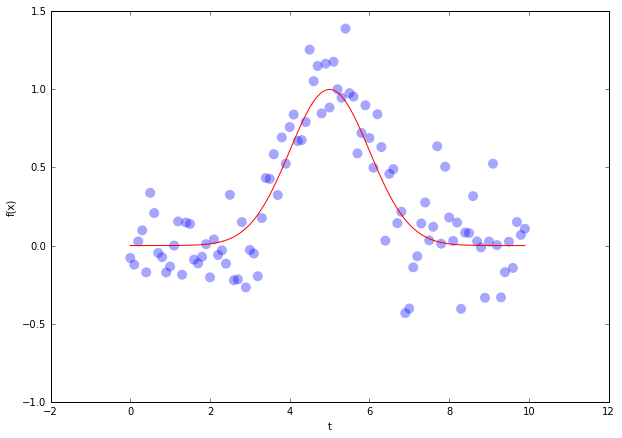

In [4]:
plt.figure(figsize=(10,7)) #adjust size of figure
plt.xlabel('t')            #x-label
plt.ylabel('f(x)')         #y-label
plt.plot(t,g,c='red')      
plt.scatter(t,d,c='blue', s=100.0, alpha=0.35, edgecolors="none")
plt.show()

## Estimate the posterior, $\mathcal{P}$, on model parameters $x={a,b,c,z}$ given our data $d$

We will be using Markov-Chain-Monte-Carlo, first we define our Likeihood function

In [5]:
def loglikelihood(func,pars,t,data,derr):
    "Returns the log-likelihood for independent Gaussians"
    m=func(t,a=pars[0],b=pars[1],c=pars[2],z=pars[3]) #get model
    n=len(data)
    #add in functionality to scale errors
    if len(pars) > 4:
        dscale=pars[4]
    else:
        dscale=1.0
    ll=-n*np.log(2*np.pi)-sum(derr*derr*dscale*dscale)-sum((m-data)*(m-data)/(derr*derr*dscale*dscale))
    
    return ll;

and we define our Priors:

In [6]:
def lprior(pars):
    "Simple prior with log(pr)=0 with valid parameters, otherwise return large small value"
    a=pars[0];b=pars[1];c=pars[2];z=pars[3];
    if len(pars) > 4:
        dscale=pars[4]
    else:
        dscale=1.0
    badlpr=-1.0e30    #bad lpr value
    lpr=0.0           #default return value
    if a > 5:
        lpr=badlpr
    if a < -5:
        lpr=badlpr
    if b > 10:
        lpr=badlpr
    if b < 0:
        lpr=badlpr
    if c > 10:
        lpr=badlpr
    if c < 0:
        lpr=badlpr
    #no prior on z.
    if dscale < 0:
        lpr=badlpr
    
    return lpr;

# Markov Chain Monte Carlo, the Metropolis-Hastings Algorithm, and the Gibbs Sampler

Excerpts from From Ford, E. 2005 AJ 129, 1706:

> Bayesian inference using Markov chain Monte Carlo (MCMC) simulations provides a method for estimating the uncertainty of fitted parameters.  

In the next section f(x) refers to the posterior distribution $p(x~|~d)$

>The goal of the MCMC method is to generate a chain (i.e., sequence) of states (i.e., sets of parameter values $x_i$) that are sampled from a desired probability distribution [$f(x)$]. Such a chain can be calculated by specifying an initial set of parameter values, $x_0$, and a transition probability, $p(x_{n+1}|x_n)$. The Monte Carlo aspect of MCMC simulation refers to randomness in the generation of each subsequent state. The Markov property specifies that the probability distribution for determination of $x_{n+1}$ can depend on xn but not previous states. If the Markov chain is reversible, that is, if 

> $$ f(x)p(x~|~x') = f(x')p(x'~|~x) $$

>and it is aperiodic and irreducible, then it can be proved that the Markov chain will eventually converge to the stationary distribution $f(x)$ (Gilks et al. 1995). The requirement that the chain be irreducible guarantees that it will be possible for the chain to reach every state with nonzero probability from any initial state.

A Markov-Chain refers to sets of model parameters which are generated by selecting a trail parameter set and using the relative probabilities to randomly select or reject the trail set.  To show this works we will use the Metropolis-Hasting (M-H) algorithm and walk through the algorthim.

(adopted from Ford 2005) :  
 1) Initilize the chain with $n=1$, $x_n=x_0$ (current state)  
 2) Generate a trial state ($x'$) with an appropriate transition function $q(x'~|~x_n)$  
 3) Calculate the Likelihood for the trial and Likelihood for the transition state  
 4) Determine the acceptance probability $\alpha(x'|x)$  
 5) Draw a random number $u$=[0,1]  
 6) If $u \leq \alpha(x'~|~x)$ then $x_{n+1} = x'$ else $x_{n+1} = x_n$  
 7) n=n+1  
 8) GOTO step 2  
 
The acceptance probability for the M-H algorithm is,

$$ \alpha(x'~|~x) = min\left[ \frac{p(x'~|~d)~q(x~|~x')}{p(x'~|~d)~q(x'~|~x)},~1   \right]$$

We will use a Gibbs sampler as our choice for $q(x~|~x')$,

$$ q(x'_{\mu}|x_{\mu}) = \frac{1}{\sqrt{2\pi\beta^2_{\mu}}} exp \left[ -\frac{(x'_{\mu}-x_{\mu})^2}{2\beta^2_{\mu}} \right] $$

Rather than trying to alter all components of $x$ and estimating the transition probabilities $q$ over a multi-dimensional space, the Gibbs sampler operations on one variable at a time.  The adoption of a Gaussian as our transition function means that $q(x'~|~x)=q(x~|~x)$ which reduces the M-H acceptance probability to,

$$ \alpha(x'~|~x) = min\left[ \frac{p(x'~|~d)}{p(x'~|~d)},~1   \right]$$.

In step(2) from our M-H recipe we now randomly select one component of $x$ to change at a time.  The Gibbs sample has tunable parameters $\beta_{\mu}$ for each parameter.  The choice of $\beta$ determines much to change a parameter value in each new state.  If $\beta$ is too large, then acceptance of new states will be low.  If $\beta$ is too small then acceptance will be too high.  In both cases, the M-H algorithm will be very slow towards reaching convergence and estimating $p(x~|~d)$.  

## Let's implement the M-H algorithm with a Gibb's sampler.

In [7]:
def mhmcmc(x,llx,beta,t,d,derr):
    "A Metropolis-Hastings MCMC sampler"
    
    xt=np.copy(x)                            #make a copy of our current state to the trail state
    npars=len(x)                             #number of parameters
    n=int(np.random.rand()*npars)            #random select a parameter to vary.
    
    xt[n]=xt[n]+np.random.normal(0.0,beta[n])#Step 2: Generate trial state with Gibbs sampler 
    
    llxt=loglikelihood(gaussian,xt,t,d,derr) #Step 3 Compute log(p(x'|d))
    llxt=llxt+lprior(xt) 
    
    alpha=min(np.exp(llxt-llx),1.0)          #Step 4 Compute the acceptance probability
    
    u=np.random.rand()                       #Step 5 generate a random number

    if u <= alpha:                           #Step 6, compare u and alpha
        xp1=np.copy(xt)                      #accept new trial
        llxp1=np.copy(llxt)
        ac=0                                 #Set ac to mark acceptance
    else:
        xp1=np.copy(x)                       #reject new trial
        llxp1=np.copy(llx)
        ac=1                                 #Set ac to mark rejectance
        
    xp1=np.array(xp1)
    return xp1,llxp1,ac;                     #return new state and log(p(x|d)) 

## Let's use our M-H MCMC algorithm and generate 50 000 chains.

In [8]:
chain=[]                                  #Initialize list to hold chain values
accept=[]                                 #Track our acceptance rate
beta=[0.2,0.2,0.2,0.2]                    #our choice of beta for the Gibb's sampler. 
x=[0.8,4.0,0.2,0.5]                       #Step 1: initialize state 
chain.append(x)                           #Step 1: start the chain
accept.append(0)
llx=loglikelihood(gaussian,x,t,d,derr)    #pre-compute the log-likelihood for Step 3
llx=llx+lprior(x)                         #Don't forget your priors!

niter=50000                               #number of iterations
for i in range(0,niter):
    x,llx,ac = mhmcmc(x,llx,beta,t,d,derr)
    chain.append(x)
    accept.append(ac)

chain=np.array(chain)                     #Convert list to array

## Examining the MCMC output  

Let's start by looking after few 500 chains.

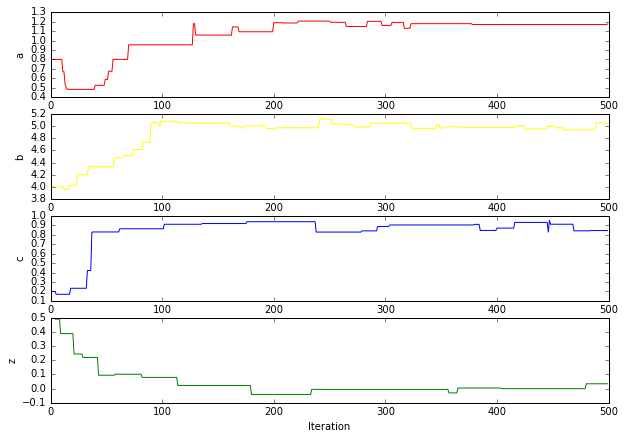

In [9]:
plt.figure(figsize=(10,7))              #adjust size of figure

plt.subplot(4, 1, 1)      
plt.plot(chain[:500,0],c='r')           #plot parameter a
plt.ylabel('a')                         #y-label

plt.subplot(4, 1, 2)
plt.plot(chain[:500,1],c='yellow')      #plot parameter b
plt.ylabel('b')                         #y-label

plt.subplot(4, 1, 3)
plt.plot(chain[:500,2],c='b')           #plot parameter c
plt.ylabel('c')                         #y-label

plt.subplot(4, 1, 4)
plt.plot(chain[:500,3],c='g')           #plot parameter z
plt.xlabel('Iteration')                 #x-label
plt.ylabel('z')                         #y-label

plt.show()

The initial values of used to initiate the MCMC routine were fairly far from their optimum spot, but after about 50-75 iterations, the value for each parameter settles towards the expected values of a=1,b=5,c=1.  This initial settling is known as **burn in**.  There are various techniques for identifying burning, including visual inspection.  For now lets clip out the first 200 chains.

In [10]:
chain=np.copy(chain[200:,:])   #cut first 100 chains

Let's look at the remaining distributions.

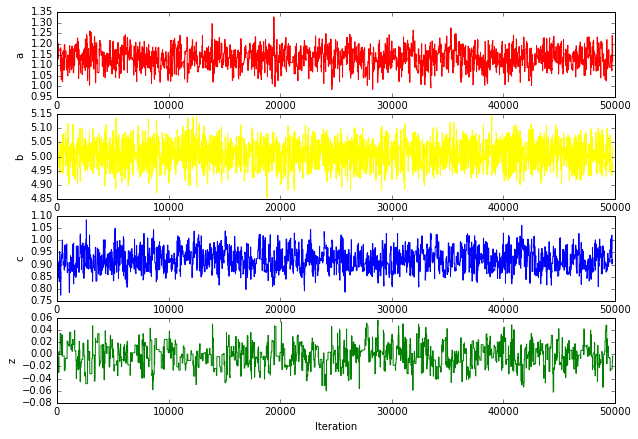

In [11]:
plt.figure(figsize=(10,7)) #adjust size of figure

plt.subplot(4, 1, 1)      
plt.plot(chain[:,0],c='r')  #plot parameter a
plt.ylabel('a')             #y-label

plt.subplot(4, 1, 2)
plt.plot(chain[:,1],c='yellow')   #plot parameter b
plt.ylabel('b')                   #y-label

plt.subplot(4, 1, 3)
plt.plot(chain[:,2],c='b')  #plot parameter c
plt.xlabel('Iteration')     #x-label
plt.ylabel('c')             #y-label

plt.subplot(4, 1, 4)
plt.plot(chain[:,3],c='g')  #plot parameter z
plt.xlabel('Iteration')     #x-label
plt.ylabel('z')             #y-label

plt.show()

## Means and Standard Deviation

In [12]:
label=['a','b','c','z']  
for i in range(0,len(chain[1,:])):
    print(label[i],np.mean(chain[:,i]),np.std(chain[:,i]))

a 1.13328381173 0.0442002258364
b 5.00913342774 0.0404466137576
c 0.920973820694 0.0417682832095
z -0.00223088253904 0.0190435262152


## Making a Triangle Plot

In [13]:
def triplot(chain,label,colour,nbin):
    "Making a Triangle Plot"

    nullfmt = NullFormatter()       # removing tick labels
    deffmt = ScalarFormatter()      # adding tick labels
    n=len(chain[1,:])               # determine number of subplots
    plt.figure(1, figsize=(10, 10))   # make a square figure
    wsize=0.9/n                     # size of individual panels

    prange=np.zeros(shape=(n,2))    #store range of parameters in chains 
    for i in range(0,n):
        prange[i,0]=min(chain[:,i]) #find minimum values
        prange[i,1]=max(chain[:,i]) #find maximum values

    for j in range(0,n):        #loop over each variable
        for i in range(j,n):    #loop again over each variable 
            left, width = 0.1+j*wsize, wsize        #determine panel size: left position and width
            bottom, height = 0.9-i*wsize, wsize     #determine panel size: bottom position and width
            rect_scatter = [left, bottom, width, height]#save panel size position    
            axScatter = plt.axes(rect_scatter)          #set panel size
        
            #put histogram on diagonals, scatter plot otherwise 
            if i == j:
                plt.hist(chain[:,j],nbin,histtype='stepfilled', facecolor=colour[i], alpha=0.8)
                x1,x2,y1,y2 = plt.axis() 
                plt.axis((prange[j,0],prange[j,1],y1,y2))
            else:
                axScatter.scatter(chain[:,j],chain[:,i],c="black", s=5.0, alpha=0.1, \
                 edgecolors="none")
                plt.axis((prange[j,0],prange[j,1],prange[i,0],prange[i,1]))   
            
            #to use a sensible x-tick range, we have to do it manually.
            dpr=(prange[j,1]-prange[j,0])/5          #make 5 ticks
            rr=np.power(10,np.floor(np.log10(dpr)))  #find sig-fig for labels
            npr=np.floor(dpr/rr)*rr                  #round off tick marks
            plt.xticks(np.arange(np.floor(prange[j,0]/rr)*rr+npr, \
             np.floor(prange[j,1]/rr)*rr,npr),rotation=30) #make ticks
        
            if i != j:    
                #use a sensible y-tick range, we have to do it manually
                dpr=(prange[i,1]-prange[i,0])/5             #make 5 ticks
                rr=np.power(10,np.floor(np.log10(dpr)))     #find sig-fig for labels
                npr=np.floor(dpr/rr)*rr                     #round off tick marks
                plt.yticks(np.arange(np.floor(prange[i,0]/rr)*rr+npr,\
                 np.floor(prange[i,1]/rr)*rr,npr),rotation=0) #make ticks
        
            axScatter.xaxis.set_major_formatter(nullfmt)  #default is to leave off tick mark labels
            axScatter.yaxis.set_major_formatter(nullfmt)
        
            #if we are on the sides, add tick and axes labels
            if i==n-1:
                axScatter.xaxis.set_major_formatter(deffmt)
                plt.xlabel(label[j]) 
            if j==0 :
                if i > 0:
                    axScatter.yaxis.set_major_formatter(deffmt)
                    plt.ylabel(label[i]) 


    plt.show()
    
    return;

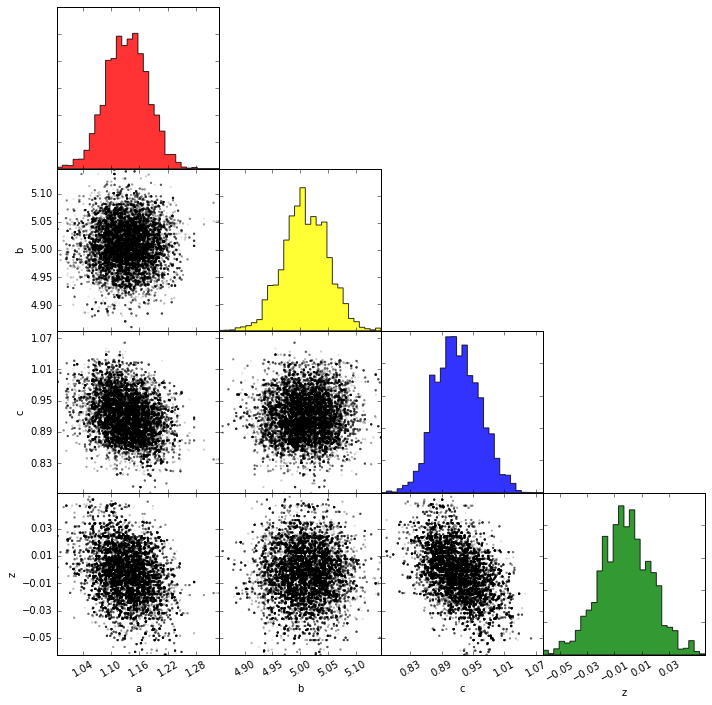

In [14]:
label=['a','b','c','z']        # Labels for the plots
colour=['r','yellow','b','g']  # Set colours
nbin=30                        # Number of bins for histogram
triplot(chain,label,colour,nbin)

# Assumptions

The biggest assumption we made in our analysis, was perfect knownledge of the measurement uncertainty $\sigma$.  We can lighten this restriction by allowing for a scale-factor to be fit 

In [15]:
chain=[]                                  #Initialize list to hold chain values
accept=[]                                 #Track our acceptance rate
beta=[0.2,0.2,0.2,0.2,0.1]      #adding a scale factor for the errors 
x=[0.8,4.0,0.2,0.5,1.0]         #adding a guess for the scale-factor, Step 1: initialize state  
chain.append(x)                           #Step 1: start the chain
accept.append(0)
llx=loglikelihood(gaussian,x,t,d,derr)    #pre-compute the log-likelihood for Step 3
llx=llx+lprior(x)                         #Don't forget your priors!

niter=50000                               #number of iterations
for i in range(0,niter):
    x,llx,ac = mhmcmc(x,llx,beta,t,d,derr)
    chain.append(x)
    accept.append(ac)

chain=np.array(chain)                     #Convert list to array

chain=np.copy(chain[200:,:])   #cut first 100 chains

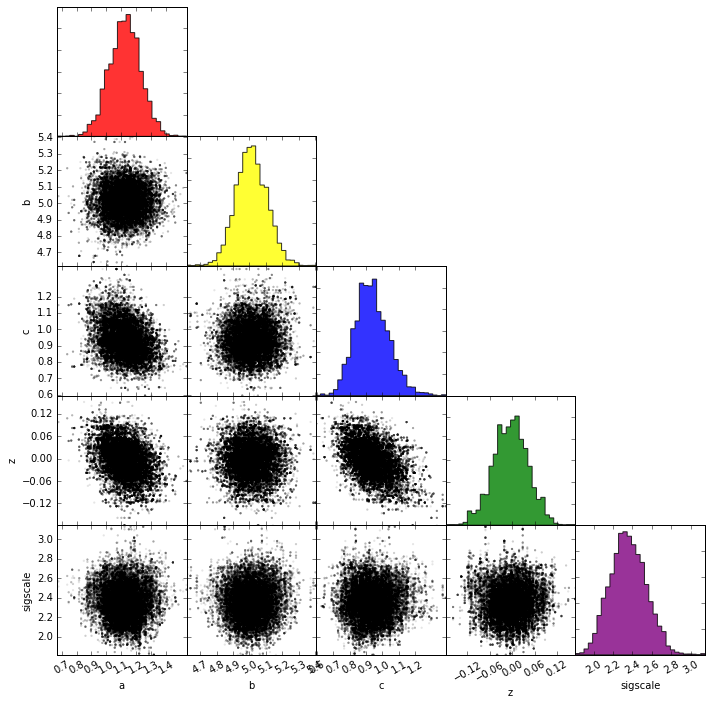

a 1.12501562975 0.104944578105
b 5.01258830356 0.0966870106227
c 0.937075727642 0.103841714378
z -0.00412306491039 0.0463440467969
sigscale 2.35769165535 0.184574384386


In [16]:
label=['a','b','c','z','sigscale']        # Labels for the plots
colour=['r','yellow','b','g','purple']  # Set colours
nbin=30                        # Number of bins for histogram
triplot(chain,label,colour,nbin)
for i in range(0,len(chain[1,:])):
    print(label[i],np.mean(chain[:,i]),np.std(chain[:,i]))

The models prefer errors that are twice as large are we assumed.  All parameter are all within 1$\sigma$ of the groud truth.